In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%bash
uname -a
whoami

edmFileUtil root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C0D83139-4A6E-E711-B1A9-02163E0137FC.root
edmFileUtil root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root

Linux vinavx3.cern.ch 3.10.0-514.10.2.el7.x86_64 #1 SMP Fri Mar 3 00:04:05 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux
innocent
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C0D83139-4A6E-E711-B1A9-02163E0137FC.root
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C0D83139-4A6E-E711-B1A9-02163E0137FC.root (1 runs, 1 lumis, 1522 events, 2449095209 bytes)
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root
root://eoscms.cern.ch///store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root (1 runs, 3 lumis, 4077 events, 2088712010 bytes)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
from multiprocessing import Pool
from DataFormats.FWLite import Handle, Events

Welcome to JupyROOT 6.10/01


In [4]:
xrd = 'root://cms-xrd-global.cern.ch//'
tier0 = 'root://cms-xrd-tzero.cern.ch//' # 'file:/eos/cms/tier0'
tier2 = 'root://eoscms.cern.ch//' #'file:/eos/cms'
myTracking = 'root://eoscms.cern.ch///store/group/phys_tracking/vincenzo/run2017/'

def oldStuff() :
    files = [\
    '/store/data/Run2016H/JetHT/AOD/PromptReco-v2/000/283/408/00000/AE49FDAB-8398-E611-9B98-02163E014388.root',\
    '/store/data/Run2016H/JetHT/AOD/PromptReco-v2/000/283/408/00000/88FB6BA5-7B98-E611-B25E-FA163EE1CC08.root',\
    '/store/data/Run2017B/SingleMuon/AOD/PromptReco-v2/000/299/061/00000/5C4984B0-B86A-E711-837F-02163E01A792.root',
    '/store/data/Run2017B/SingleMuon/AOD/PromptReco-v2/000/299/067/00000/B4146406-F66A-E711-B9C9-02163E014389.root',\
            ]
    return map(lambda x : xrd+x,files)


def jetHT2017C() :
    files = [\
    '/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/443/00000/7C92F761-A270-E711-90A8-02163E014506.root',\
    '/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/649/00000/D0BA6C4A-DB71-E711-99BC-02163E013910.root',\
    '/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/592/00000/44735821-ED70-E711-A9F3-02163E019C7D.root',\
    '/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/478/00000/7C39B1F9-A970-E711-AC40-02163E0138D5.root',\
    '/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/480/00000/9276CDF3-B870-E711-9878-02163E019D8F.root',\
    #'/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/478/00000/E2BB4D9E-A870-E711-8684-02163E0142DF.root',\
    '/store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/420/00000/5EC981C1-426E-E711-9C05-02163E0135F2.root',\
            ]
    return map(lambda x : tier0+x,files)
    
def express2017C() :
    files = [\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/592/00000/1482C818-456E-E711-A4AC-02163E01A3E1.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4CA2B934-716E-E711-B4F0-02163E01A3E5.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/523D4165-4A6E-E711-B186-02163E012A87.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C0D83139-4A6E-E711-B1A9-02163E0137FC.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/C6AE7442-4A6E-E711-864C-02163E019D7E.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/4269D74E-4A6E-E711-847B-02163E01A487.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/2449BE69-4A6E-E711-BCD5-02163E0128FE.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/593/00000/9C51DE1E-4A6E-E711-9701-02163E019E83.root',\
    '/store/express/Run2017C/ExpressPhysics/FEVT/Express-v1/000/299/649/00000/28D1AE00-2170-E711-96CA-02163E019D3B.root'\
    ]
    return map(lambda x : tier2+x,files)

def myFiles() :
    files = [\
             'JetHT_reco299592.root',\
             'JetHT_tkreco299592.root',\
             ]
    return map(lambda x : myTracking+x,files)

In [5]:
label = "generalTracks"
quality = "highPurity"

In [6]:
def runid(event,lumi) :
    id = event.object().id()
    a=event.getByLabel('scalersRawToDigi', lumi)
    return '{:d}:{:d}:{:.2e}'.format(int(id.run()),int(id.luminosityBlock()),lumi.product()[0].instantLumi())
def skip2Lumi(events,ls):
    for i in range(0,events.size()):
        a= events.to(i)
        id = events.object().id()
        if (int(id.luminosityBlock())==ls) : return i
    return events.size()

In [7]:
def loadTk(events,tracks,vertices, fe) :
    tkParsA = []
    tkHitsA = []
    for i in range(fe,events.size()):
      if (len(tkParsA) > 1000000) : break
      a= events.to(i)
      if (i%500==0) : 
        id = events.object().id()
        evid = '{:d}:{:d}:{:d}'.format(int(id.run()),int(id.luminosityBlock()), int(id.event()))
        print "Event", i , evid
      a=events.getByLabel(label, tracks)
      a=events.getByLabel("offlinePrimaryVertices",vertices)
      pv = vertices.product()[0]
      if (not pv.isValid()) : continue
      pvp = pv.position()
      for tk in tracks.product() :
        if (not tk.quality(tk.qualityByName(quality))) : continue
        if (tk.pt()<0.7) : continue
        if (abs(tk.dz(pvp))>0.5) : continue # only PV tracks
        pattern = tk.hitPattern()
        if (pattern.numberOfValidHits()<8) : continue
        if (pattern.numberOfValidPixelHits()<1) : continue
        tkParsA.append([tk.eta(),tk.phi(),tk.pt(),\
                        tk.dxy(pvp),tk.dxyError(), tk.dz(pvp), tk.dzError(),\
                        pattern.numberOfValidHits(),pattern.numberOfValidPixelHits(),tk.ndof(),tk.chi2(),tk.originalAlgo()-4])
        tkHitsA.append([pattern.getTrackerLayerCase(0,1,1), pattern.getTrackerLayerCase(1,1,1),\
                        pattern.getTrackerLayerCase(0,1,2), pattern.getTrackerLayerCase(1,1,2),\
                        pattern.getTrackerLayerCase(0,2,1), pattern.getTrackerLayerCase(1,2,1)])

    print len(tkParsA)
    tkPars = np.array(zip(*tkParsA))
    print len(tkPars)
    tkHits = np.array(zip(*tkHitsA))
    print len(tkHits)
    return tkPars,tkHits

In [8]:
def processIt(fevents) :
    print fevents
    events = Events(fevents)
    tracks = Handle("std::vector<reco::Track>")
    lumi = Handle("std::vector<LumiScalers>")
    vertices = Handle("vector<reco::Vertex>")
    a= events.to(0)
    ls = int(events.object().id().luminosityBlock())
    if (ls==103) : ls=105
    fe = skip2Lumi(events,ls)
    a= events.to(fe)
    runid0 = runid(events,lumi)
    print runid0
    tkPars, tkHits = loadTk(events,tracks,vertices,fe)
    runidl = runid(events,lumi)
    print runidl
    return (runid0+'-->'+runidl, tkPars, tkHits)

In [9]:
p = Pool(4)

root://cms-xrd-tzero.cern.ch///store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/592/00000/44735821-ED70-E711-A9F3-02163E019C7D.root
root://cms-xrd-tzero.cern.ch///store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/443/00000/7C92F761-A270-E711-90A8-02163E014506.root
root://cms-xrd-tzero.cern.ch///store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/649/00000/D0BA6C4A-DB71-E711-99BC-02163E013910.root
root://cms-xrd-tzero.cern.ch///store/data/Run2017C/JetHT/AOD/PromptReco-v1/000/299/478/00000/7C39B1F9-A970-E711-AC40-02163E0138D5.root
299592:83:1.44e+04
Event 0 299592:83:79658055
299649:69:1.66e+04
Event 0 299649:69:64632179
299443:56:1.63e+04
Event 0 299443:56:16216001
299478:84:1.29e+04
Event 0 299478:84:119847131
Event 500 299592:83:80191770
Event 1000 299592:83:79689730
Event 1500 299592:83:80089575
Event 2000 299592:84:81963743
Event 500 299443:56:17792575
Event 2500 299592:84:82392943
Event 500 299649:69:63947887
Event 500 299478:84:120066050
Event 3000 299592:84:81149597
Event 35

In [10]:
files = jetHT2017C() # express2017C() # myFiles() $oldStuff() #
t = -time.time()
ret = p.map(processIt,files)
t +=time.time()
print t
runid0, tkPars, tkHits = zip(*ret)
print runid0
print len(tkHits)

733.999281883
('299443:56:1.63e+04-->299443:132:1.59e+04', '299649:69:1.66e+04-->299649:318:1.46e+04', '299592:83:1.44e+04-->299592:98:1.42e+04', '299478:84:1.29e+04-->299478:100:1.01e+04', '299480:98:1.22e+04-->299480:363:1.11e+04', '299420:6:1.43e+04-->299420:35:1.40e+04')
6


In [11]:
p.terminate()

In [42]:
def eff(var,tkPars,tkHits) :
    hp = np.greater(tkPars[2],4.0)
    pv = np.less(abs(tkPars[5]),0.1) # &np.less(abs(tkPars[3]),0.01)
    valL2 = np.equal(tkHits[2],0)
    valF1 = np.equal(tkHits[4],0)
    hp = hp&(valL2)&pv # |valF1)
    nbins = 62
    yv,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp*np.equal(tkHits[0],0)) 
    yl,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp*np.equal(tkHits[0],1)) 
    #yi,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp*np.equal(tkHits[0],2)) 
    ym,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp*np.equal(tkHits[1],1)) 
    ya=yv+ym # +yl
    # y2,x = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp)
    x.resize(len(yv))
    return x,yv/ya

In [50]:
from scipy.stats import norm
import numpy.ma as ma
def sip(var,tkPars,tkHits) :
    hp = np.greater(tkPars[2],4.0)
    pvz = np.less(abs(tkPars[5]),0.1)
    pvt = np.less(abs(tkPars[3]),0.05)
    valL1 = np.equal(tkHits[0],0)
    valL2 = np.equal(tkHits[2],0)
    valF1 = np.equal(tkHits[4],0)
    hp1 = hp&(valL1)
    hp2 = hp&((valL2) & np.logical_not(valL1))
    
    nbins = 62
    ye1,vx = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=tkPars[4]*hp1*pvz)
    ye2,vx = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=tkPars[4]*hp2*pvz)
    ya1,vx = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp1*pvz)
    ya2,vx = np.histogram(tkPars[var],np.linspace(-3.1,3.1,nbins),weights=1.*hp2*pvz)

    vx.resize(len(ye2))


    nbins = 100
    yt1,x = np.histogram(tkPars[3]/tkPars[4],np.linspace(-10.,10.,nbins),weights=1.*hp1*pvz,density=True)
    masked = ma.masked_where(~(hp1&pvz),ma.masked_outside(tkPars[3]/tkPars[4],-2.5,2.5))
    print norm.fit(masked[~masked.mask])
    yz1,x = np.histogram(tkPars[5]/tkPars[6],np.linspace(-10.,10.,nbins),weights=1.*hp1*pvt,density=True) 
    yt2,x = np.histogram(tkPars[3]/tkPars[4],np.linspace(-10.,10.,nbins),weights=1.*hp2*pvz,density=True) 
    masked = ma.masked_where(~(hp2&pvz),ma.masked_outside(tkPars[3]/tkPars[4],-2.5,2.5))
    print norm.fit(masked[~masked.mask])
    yz2,x = np.histogram(tkPars[5]/tkPars[6],np.linspace(-10.,10.,nbins),weights=1.*hp2*pvt,density=True)
    x.resize(len(yt1))
    return x,yt1,yz1,yt2,yz2,vx,ye1/ya1,ye2/ya2    

In [51]:
eta=0
phi=1
pt=2

In [52]:
effH = map(eff,[phi]*len(tkPars),tkPars, tkHits)
print len(effH)

6


In [53]:
sipH = map(sip,[eta]*len(tkPars),tkPars, tkHits)
print len(sipH)

(-0.023130881950346707, 0.90821937306956835)
(-0.028930161146180904, 0.94311044671100142)


/cvmfs/cms.cern.ch/slc7_amd64_gcc630/external/py2-pippkgs/5.0-ghjeda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in divide


(-0.020686047399021346, 0.91336488995032095)
(-0.027121020025473012, 0.9506042024796969)
(-0.020159793548760303, 0.89961471084568856)
(-0.018846643048355587, 0.95001910442299164)
(-0.010914659087499822, 0.90430655391734227)
(-0.035695226488584565, 0.96175404204583415)
(-0.015098072688079063, 0.90033767473425019)
(-0.0043339125429965901, 0.95706639926842152)
(-0.059090659205778537, 0.91540833261365129)
(-0.046973801851749909, 0.95807815759121762)
6


In [54]:
from scipy.optimize import leastsq
fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2) # +p[3]
errfunc  = lambda p, x, y: (y - fitfunc(p, x))  #   /np.sqrt(np.clip(y,a_min=0.00001,a_max=None))
init  = [0.5, 0.0, 1.0] # , 0.5]

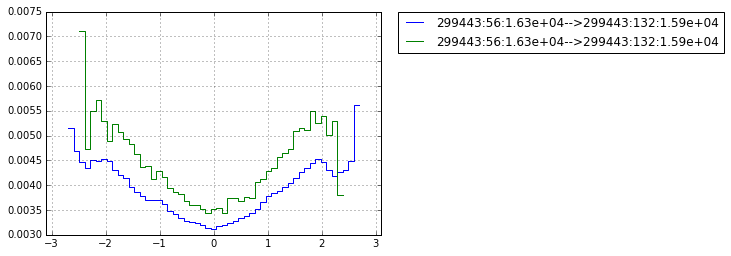

[ 0.41769177 -0.12571408  0.88795249]
[ 0.38010688 -0.1402932   0.94335059]


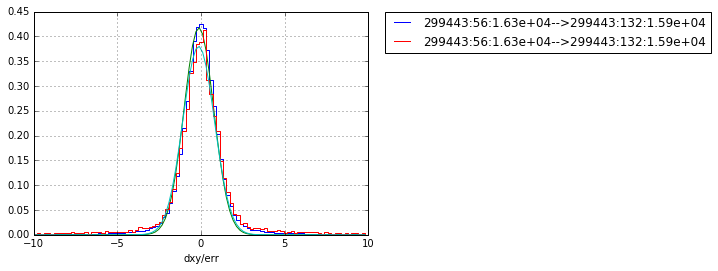

[ 0.40525879 -0.10458476  0.89364321]


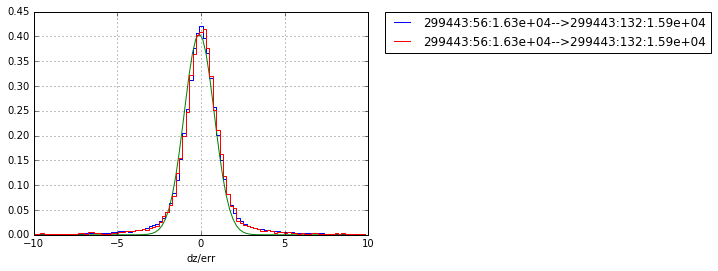

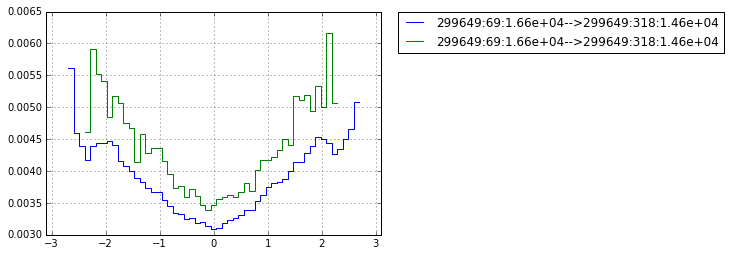

[ 0.41365464 -0.12485264  0.89810784]
[ 0.37815753 -0.13878396  0.95266367]


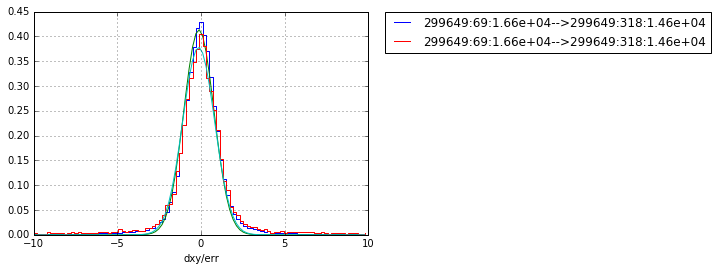

[ 0.39926189 -0.10696201  0.90441607]


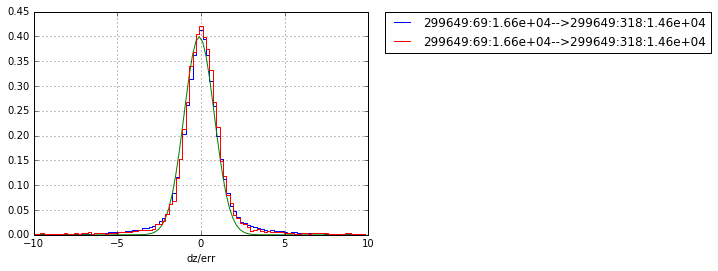

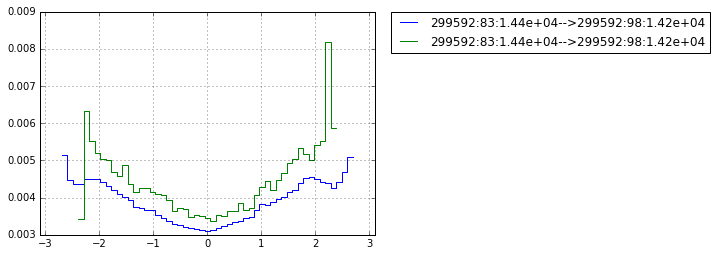

[ 0.4229399  -0.12363367  0.88026762]
[ 0.37600527 -0.11859351  0.95110243]


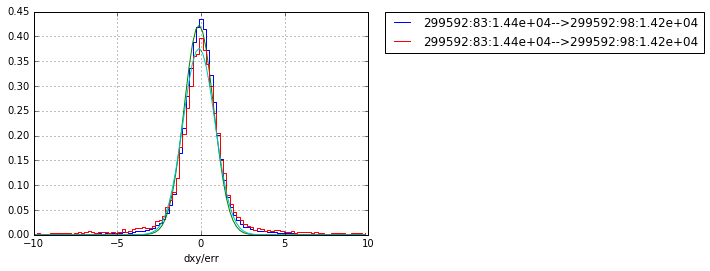

[ 0.41769435 -0.10377071  0.87589992]


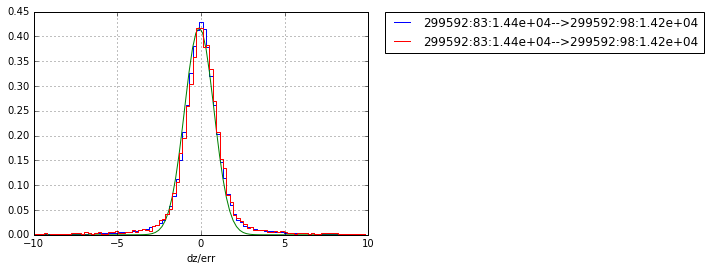

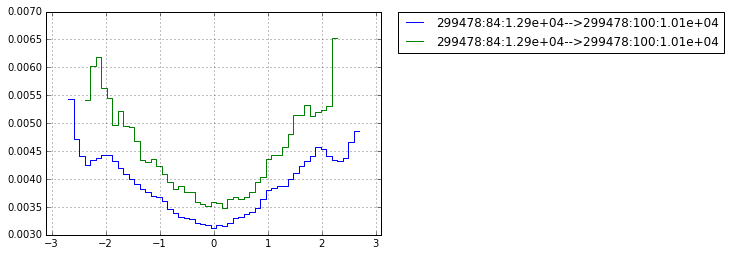

[ 0.42036715 -0.11181495  0.88442565]
[ 0.36617375 -0.14144824  0.96842   ]


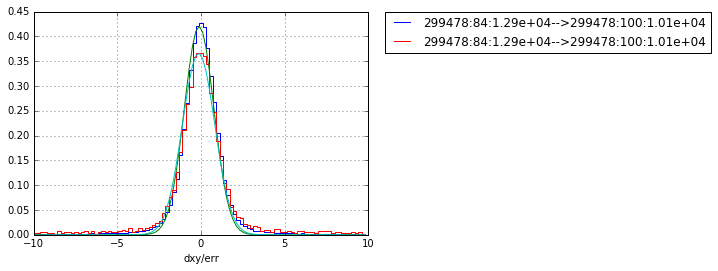

[ 0.41502326 -0.10050603  0.88332016]


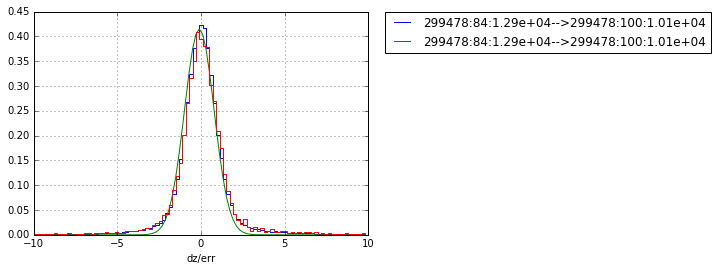

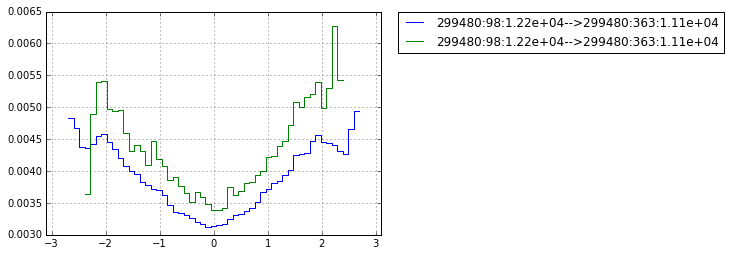

[ 0.42330705 -0.11618255  0.88073092]
[ 0.37038314 -0.10330359  0.96241713]


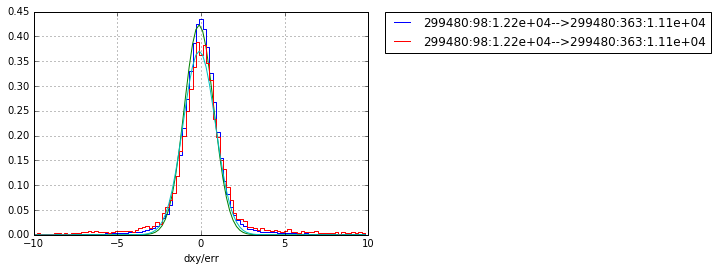

[ 0.42411817 -0.1038898   0.86684845]


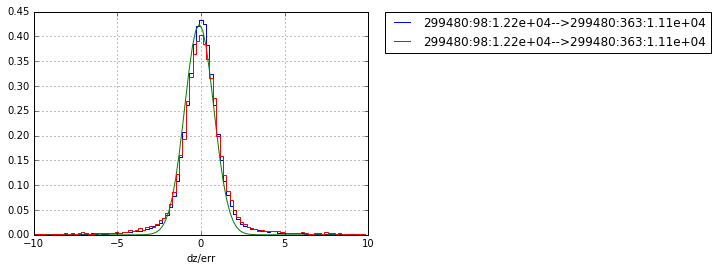

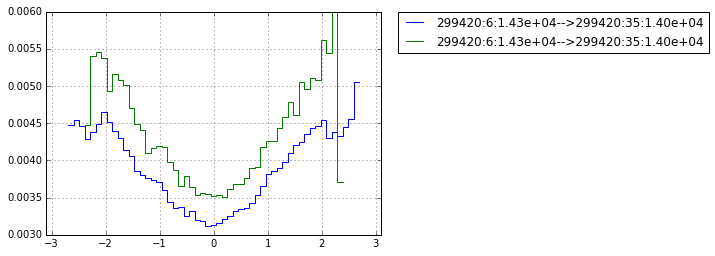

[ 0.41241932 -0.16345715  0.90022695]
[ 0.37725846 -0.1534458   0.96219425]


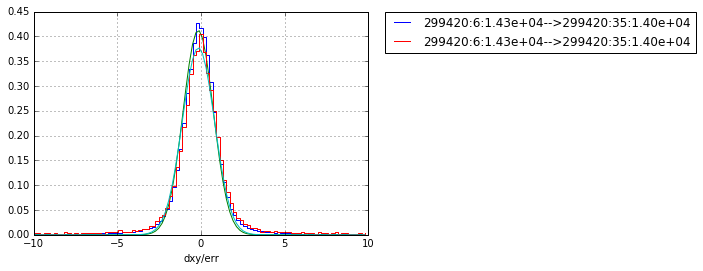

[ 0.39010317 -0.11170969  0.92970572]


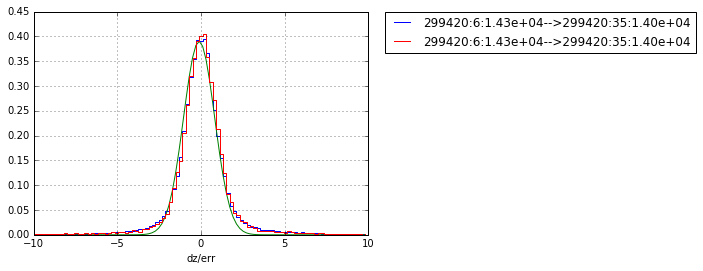

In [55]:
i=0
for b in sipH:
    plt.step(b[5],b[6],where='post',label=runid0[i])
    plt.step(b[5],b[7],where='post',label=runid0[i])
    plt.xlim(-3.1, 3.1)
#    plt.ylim(0.5, 1.1)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.legend(loc='upper right')
    plt.show()
    
    plt.step(b[0],b[1],where='post',label=runid0[i])
    out   = leastsq( errfunc, init, args=(b[0][30:70], b[1][30:70]))
    c = out[0]
    print c
    plt.plot(b[0], fitfunc(c, b[0]))
    plt.step(b[0],b[3],where='post',label=runid0[i])
    out   = leastsq( errfunc, init, args=(b[0][30:70], b[3][30:70]))
    c = out[0]
    print c
    plt.plot(b[0], fitfunc(c, b[0]))
    plt.xlim(-10., 10.)
    #plt.ylim(0.5, 1.1)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.legend(loc='upper right')
    plt.xlabel('dxy/err')
#    i+=1
    plt.show()
    plt.step(b[0],b[2],where='post',label=runid0[i])
    out   = leastsq( errfunc, init, args=(b[0][30:70], b[2][30:70]))
    c = out[0]
    print c
    plt.plot(b[0], fitfunc(c, b[0]))
    plt.step(b[0],b[4],where='post',label=runid0[i])
    plt.xlim(-10., 10.)
    #plt.ylim(0.5, 1.1)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#    plt.legend(loc='upper right')
    plt.xlabel('dz/err')
    i+=1
    plt.show()




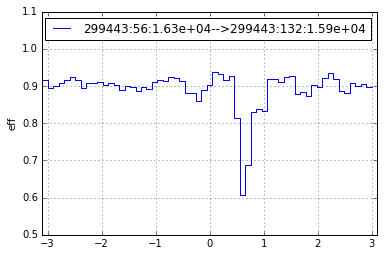

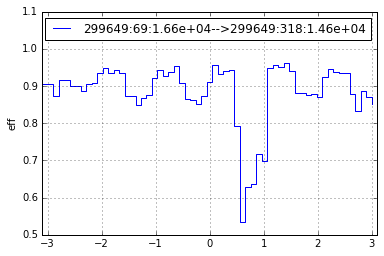

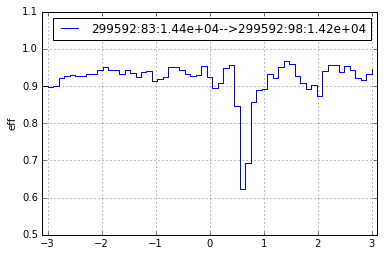

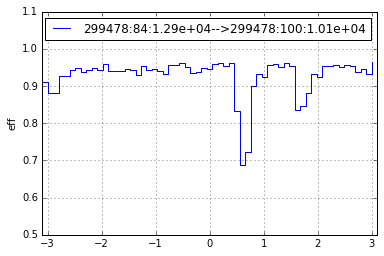

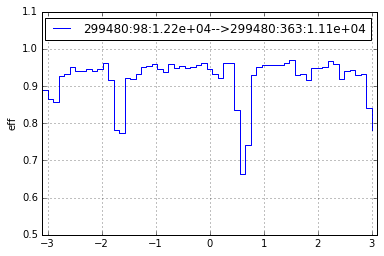

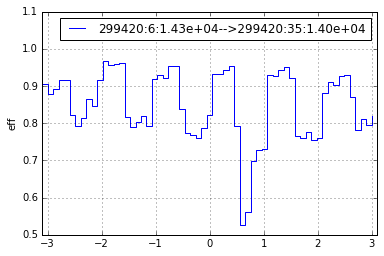

In [56]:
i=0
for b in effH:
    plt.step(b[0],b[1],where='post',label=runid0[i])
    plt.xlim(-3.1, 3.1)
    plt.ylim(0.5, 1.1)
    plt.grid(True)
#    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.legend(loc='upper right')
    plt.ylabel('eff')
    i+=1
    plt.show()
